# Relax challenge

Relax Inc. makes productivity and project management software that's popular with both individuals and teams.

Defining   an      "adopted   user"      as   a   user   who         has   logged   into   the   product   on   three   separate  days   in   at   least   one   seven­day   period  ,   identify   which   factors   predict   future   user  adoption  . 


In [1]:
# import libraries
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
user_eng = pd.read_csv('takehome_user_engagement.csv', header=0)
users = pd.read_csv('takehome_users.csv', header=0, encoding='ISO-8859-1')

In [3]:
# drop logins of the same user on the same date
user_eng['time_stamp'] = pd.to_datetime(user_eng.time_stamp).dt.floor('d')
user_eng.drop_duplicates(inplace=True)

In [4]:
# calculate if the user is adopted

# sort by user and login time, set time as index
df = user_eng.sort_values(['user_id', 'time_stamp']).set_index('time_stamp')
# resample for each day after grouping by each user
df = df.groupby('user_id').resample('1d').sum().fillna(0)
# set index back to time
df = df.drop('user_id', axis=1).reset_index().set_index('time_stamp')
# use rolling window of 7 days to compute sum
df = df.groupby('user_id').rolling(7, min_periods=1)['visited'].sum()
# find max number of logins in any given 7 days
df = df.reset_index().drop('time_stamp', axis=1).groupby('user_id').max().reset_index()
# create adopted column
df['adopted'] = (df.visited >= 3).map({True:1, False:0})

In [5]:
# merge with user data table
users_adopted = pd.merge(users, df, how='left', left_on='object_id', 
                         right_on='user_id').drop(['user_id', 'visited'], axis=1)
users_adopted['adopted'] = users_adopted.adopted.fillna(0)

In [6]:
# add more columns

# calculate number of days since creation, using the most recent login from all users
now = users.last_session_creation_time.fillna(0).apply(datetime.fromtimestamp).max()
users_adopted['days_since_creation'] = (now - pd.to_datetime(users_adopted.creation_time)).dt.days

# the column to indicate if the user invited others
users_adopted['invited_others'] = users_adopted.object_id.isin(users_adopted.invited_by_user_id).map({True:1, False:0})

# column to indicate if the user was targeted through marketing campaigns
users_adopted['marketing'] = users_adopted[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].max(axis=1)


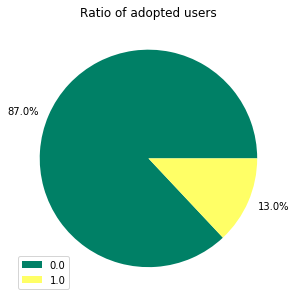

In [7]:
# count % of users in each category
x = (users_adopted.adopted.value_counts(normalize = True)*100).round(0)

# display the outcome in pie chart
x.plot(kind = 'pie', colormap = 'summer', labels = (x.astype(str) + '%'), figsize = [5,5])
plt.title('Ratio of adopted users')
plt.legend(x.index, loc = 'lower left', frameon = True)
plt.ylabel('')
plt.show()

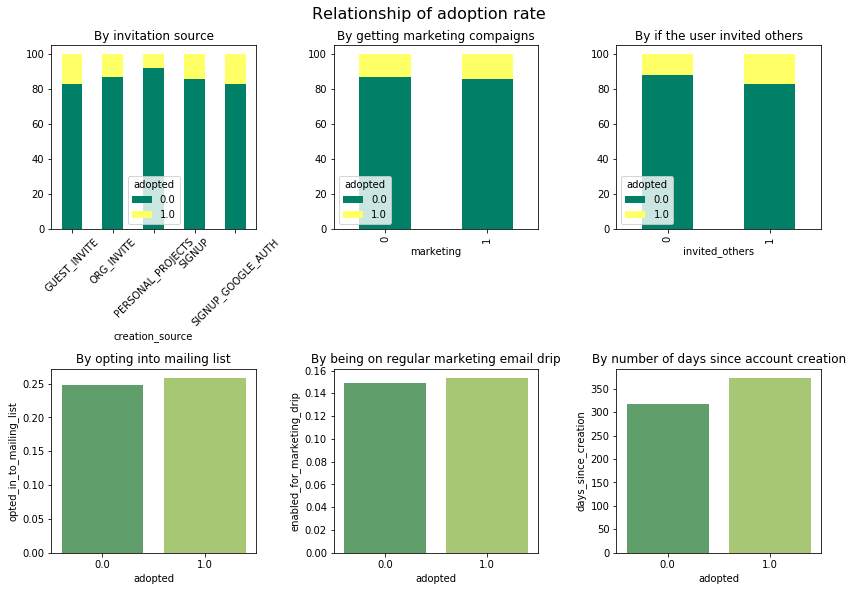

In [8]:
# plot relationship of adopted variable with other variables

plt.figure(figsize = [12,8])

ax = plt.subplot(2,3,1)
a = users_adopted[['adopted', 'creation_source', 'object_id']].groupby(['adopted', 'creation_source']).count().unstack()
a.columns = a.columns.droplevel()
a = round(a.div(a.sum())*100)
a.T.plot(kind='bar', stacked=True, colormap='summer', ax=ax)
plt.title('By invitation source')
plt.xticks(rotation=45)

ax = plt.subplot(2,3,2)
a = users_adopted[['adopted', 'marketing', 'object_id']].groupby(['adopted', 'marketing']).count().unstack()
a.columns = a.columns.droplevel()
a = round(a.div(a.sum())*100)
a.T.plot(kind='bar', stacked=True, colormap='summer', ax=ax)
plt.title('By getting marketing compaigns')

ax = plt.subplot(2,3,3)
a = users_adopted[['adopted', 'invited_others', 'object_id']].groupby(['adopted', 'invited_others']).count().unstack()
a.columns = a.columns.droplevel()
a = round(a.div(a.sum())*100)
a.T.plot(kind='bar', stacked=True, colormap='summer', ax=ax)
plt.title('By if the user invited others')

ax = plt.subplot(2,3,4)
sns.barplot(x='adopted', y='opted_in_to_mailing_list', data=users_adopted, palette='summer', ci=0, ax=ax)
plt.title('By opting into mailing list')

ax = plt.subplot(2,3,5)
sns.barplot(x='adopted', y='enabled_for_marketing_drip', data=users_adopted, palette='summer', ci=0, ax=ax)
plt.title('By being on regular marketing email drip')

ax = plt.subplot(2,3,6)
sns.barplot(data=users_adopted, x='adopted', y='days_since_creation', palette='summer',ci=0, ax=ax)
plt.title('By number of days since account creation')

plt.tight_layout()
plt.suptitle('Relationship of adoption rate', y=1.02, size=16)
plt.show()

In [9]:
# organizations that invited at least 10 users that were adopted.
a = users_adopted.groupby(['org_id']).sum().sort_values('adopted', ascending=False)
print('Organizations that invited more adopted users: ', a[a.adopted>=10].index.values)

Organizations that invited more adopted users:  [ 4  7  2  9  3 13  1 62  5  0  6 24  8 44 10]


There are only 13% of adopted users. Several factors that can predict the future user adoption are:
- the way the accoount was created (with larger percentage of adopted users that were invited as guests or used gmail for signing in)
- if this users have invited others (the ones that invided others are more likely to be adopted)
- the length of participation (the earlier the acount was created the more users were adopted)

Being subscribed to marketing campaigns did not seem to influence user adoption. Maybe it is worth to conduct a survey and incorporate improvements into marketing campaigns.

Few more things to look into:
- the organizations that invite more adopted users than others - above is the list of the ones that invited at least 10 adopted users
- to check email domains the users sign up with. are those work emails or personal ones (from yahoo, google or aol for example)